In [1]:
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from xgboost import XGBClassifier, DMatrix, plot_importance, plot_tree
from lightgbm import LGBMClassifier, Dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
catboost_params = {
    "iterations": 2000,
    "depth": 1, # 3
    "learning_rate": 0.07,
    "loss_function": "Logloss",
    "verbose": False,
    "eval_metric": 'AUC',
    "od_type": 'Iter',
    "od_wait": 300,
}

lr_params = {
    "C": 1.5,
    "fit_intercept": True,
    "max_iter": 300,
    "penalty": "l1",
    "random_state": 123,
    "solver": "liblinear"
}

catboost_columns = [
    'term',
    'acc_open_past_24mths', # 677 02
    'funded_amnt',
    'percent_per_year',
    'additional_dti', #671
    'num_accts_ever_120_pd',
    'annual_inc', # 682 024,
    'tot_hi_cred_lim',
    'purpose', # 6839 035
    'home_ownership', # 683 027
    
    'avg_cur_bal', # 684 041
    'mths_since_recent_inq',
]

catboost_cat_features = [
    'purpose',
    'home_ownership',
]

lr_cols = [
    'annual_inc',
    'acc_open_past_24mths',
    'term',
    'additional_dti',
    'tot_hi_cred_lim_log',
    'percent_per_year',
    'annual_inc_sqrt',
    'purpose_small_business',
    'is_emp_length_unknown',
    'is_not_sber_client',
    'purpose_vacation',
    'inq_last_6mths',
    'funded_amnt_mod_100',
    'num_accts_ever_120_pd',
]

lgbm_params = {
    'objective': 'binary',
    'max_depth': 1,
    'learning_rate': 0.05,
    'lambda_l2': 0.01,
    'seed': 17,
    'n_estimators': 1000,
    'min_child_weight': 40,
}

knn_params = {
    "n_neighbors": 130,
    "weights": 'distance',
}

knn_columns = [
    'percent_per_year',
    'percent',
    'term',
    'loan_income_ratio',
    'psk',
    'additional_dti',
    
    'purpose_small_business',
    'purpose_home_improvement',
    'purpose_major_purchase',
    'purpose_medical',
    'purpose_vacation',
    'purpose_wedding',
    'purpose_car',
    
    'acc_open_past_24mths',
    'num_accts_ever_120_pd',
    
    'home_ownership_MORTGAGE',
    'home_ownership_RENT',
    
    'installment',
    'is_first_loan',
    'avg_cur_bal',
    'is_emp_length_unknown',
    'even_salary',
]

lgbm_columns = [
    'percent',
    'acc_open_past_24mths',
    'avg_cur_bal',
    'loan_income_ratio',
    'annual_inc',
    'tot_hi_cred_lim',
    'additional_dti',
    'percent_per_year',
    'purpose',
    'dti',
    'home_ownership',
    'num_accts_ever_120_pd',
    'psk',
    'is_emp_length_unknown',
    'funded_amnt',
]

lgbm_cat_features = [
    'purpose',
    'home_ownership',
]

xgb_columns = [   
    'dti',
    'inq_last_6mths',
    'mths_since_recent_inq',
    'num_accts_ever_120_pd',
    'acc_open_past_24mths',
    'tot_hi_cred_lim',
    'purpose',
    'home_ownership',
    'psk',
    'percent',
    'loan_income_ratio',
    'is_emp_length_unknown',
    'funded_amnt_mod_100',   
]


xgb_params = {
    'max_depth': 1,
    'learning_rate': 0.1,
    'reg_alpha': 1,
    'reg_lambda': 10,
    'n_estimators': 1500,
}

nb_columns = [
    'percent',
    'annual_inc',
    'purpose_small_business',
    'percent_per_year',
    'additional_dti', 
    'avg_cur_bal_log',
]

bnb_columns = [
    'percent_per_year',
    'loan_income_ratio',
    'annual_inc_log',
    'percent',
    'home_ownership_RENT',
    'dti',
    'inq_last_6mths',
    'tot_hi_cred_lim',
    'funded_amnt_mod_100',
    'is_first_loan',
    'purpose_small_business',
    'num_accts_ever_120_pd',
]

rf_columns = [
    'residual_dti',
    'tot_hi_cred_lim_annual_inc_ratio',
    'funded_amnt_log',
    'dti_ratio_min',
    'mths_since_recent_inq',
    'tot_hi_cred_lim_funded_amnt_ratio',
    'waste_to_installment_ratio',
    'avg_cur_bal_log',
    'annual_inc',
    'tot_hi_cred_lim_sqrt',
    'acc_open_past_24mths_ratio',
    'inq_last_6mths',
    'tot_hi_cred_lim',
    'installment_log',
    'dti_sqrt',
    'annual_inc_log',
    'dti',
    'loan_income_ratio',
    'avg_cur_bal_sqrt',
    'additional_dti',
    'avg_cur_bal',
    'acc_open_past_24mths',
    'funded_amnt_mod_100',
    'annual_inc_sqrt',
    'dti_log',
    'term',
    'psk',
    'percent',
    'percent_per_year'
]

rf_params = {
    'n_estimators': 100,
    'max_depth': 6,
}

In [ ]:
def split_data(x_train, y_train):
    X_train_df, X_valid_df, y_train_df, y_valid_df = train_test_split()
    X_train_df = x_train[features].iloc[ind_trn]
        X_valid_df = x_train[features].iloc[ind_test]
        y_train_df = y_train.iloc[ind_trn]
        y_valid_df = y_train.iloc[ind_test]

In [78]:
def init_and_fit_model(x_train, x_test, y_train, y_test, params, cat_features, model):
    if model=='catboost':
        eval_dataset = Pool(x_test, y_test, cat_features)
        inner_model = CatBoostClassifier(**params)

        inner_model.fit(
            x_train,  
            y_train,
            cat_features,
            eval_set=eval_dataset,
            verbose=0,
            use_best_model=True,
        )
    elif model == 'logreg':
        inner_model = LogisticRegression(**params)
        inner_model.fit(x_train, y_train)
    elif model == 'lgbm':
        inner_model = LGBMClassifier(**params)
        inner_model.fit(
            x_train,  
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric='auc',
            verbose=0,
            early_stopping_rounds=50,
            categorical_feature=cat_features,
        )
    elif model == 'knn':
        inner_model = KNeighborsClassifier(**params)
        inner_model.fit(x_train, y_train)
    elif model == 'xgboost':
        inner_model = XGBClassifier(**params)

        inner_model.fit(
            x_train,  
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric='auc',
            verbose=0,
            early_stopping_rounds=150,
        )
    elif model == 'nb':
        inner_model = GaussianNB()
        inner_model.fit(x_train,y_train)
    elif model == 'bnb':
        inner_model = BernoulliNB()
        inner_model.fit(x_train, y_train)
    elif model == 'rf':
        inner_model = RandomForestClassifier(**params, random_state=17)
        inner_model.fit(x_train, y_train)
    return inner_model

def fit_models(x_train, x_test, y_train, features, cat_features, params, model='catboost', seed=17):
    X_train_df, X_valid_df, y_train_df, y_valid_df = train_test_split(
        x_train[features], y_train, random_state=seed, stratify=y_train, shuffle=True, test_size=0.5 #rs 17
    )
    
    scores = []    
    
    fitted_model = init_and_fit_model(
        X_train_df,
        X_valid_df,
        y_train_df,
        y_valid_df,
        params,
        cat_features,
        model
    )
    
    scores = roc_auc_score(y_valid_df, fitted_model.predict_proba(X_valid_df)[:, 1])
    result = fitted_model.predict_proba(x_test[features])[:, 1:].flatten()
    valid_predicts = fitted_model.predict_proba(X_valid_df)[:, 1]
    return scores, result, valid_predicts, y_valid_df

In [4]:
catboost_train = pd.read_csv('data/catboost_train.csv')
catboost_test = pd.read_csv('data/catboost_test.csv')
lgbm_train = pd.read_csv('data/catboost_train.csv')
lgbm_test = pd.read_csv('data/catboost_test.csv')
logreg_train = pd.read_csv('data/logreg_train.csv')
logreg_test = pd.read_csv('data/logreg_test.csv')

In [5]:
cat_cols = [
    'purpose',
    'home_ownership',
    'subgrade'
]

for cat_cols in cat_cols:
    le = LabelEncoder()
    lgbm_train[cat_cols] = le.fit_transform(lgbm_train[cat_cols])
    lgbm_test[cat_cols] = le.transform(lgbm_test[cat_cols])

In [6]:
# catboost_train_small, catboost_valid, catboost_y_train, catboost_y_valid = train_test_split(
#     catboost_train.drop(columns=['def'], axis=1),
#     catboost_train['def'],
#     test_size=0.2,
#     random_state=18,
#     stratify=catboost_train['def']
# )

# logreg_train_small = logreg_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
# logreg_valid = logreg_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
# logreg_y_train = logreg_train.loc[catboost_train_small.index]['def']
# logreg_y_valid = logreg_train.loc[catboost_valid.index]['def']

# lgbm_train_small = lgbm_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
# lgbm_valid = lgbm_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
# lgbm_y_train = lgbm_train.loc[catboost_train_small.index]['def']
# lgbm_y_valid = lgbm_train.loc[catboost_valid.index]['def']

# xgb_train_small = lgbm_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
# xgb_valid = lgbm_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
# xgb_y_train = lgbm_train.loc[catboost_train_small.index]['def']
# xgb_y_valid = lgbm_train.loc[catboost_valid.index]['def']

# knn_train_small = logreg_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
# knn_valid = logreg_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
# knn_y_train = logreg_train.loc[catboost_train_small.index]['def']
# knn_y_valid = logreg_train.loc[catboost_valid.index]['def']

In [66]:
y_valids = []
for seed in range(10):
    X_train_df, X_valid_df, y_train_df, y_valid_df = train_test_split(
        catboost_train, catboost_train['def'], random_state=seed, stratify=catboost_train['def'], shuffle=True, test_size=0.5
    )
    y_valids.append(y_valid_df)

In [96]:
train_dfs = []
test_dfs = []
y_valids = []
for seed in range(10):
    print(seed)
    cb_scores, cb_result, cb_oof_result, _ = fit_models(
        catboost_train,
        catboost_test,
        catboost_train['def'],
        catboost_columns,
        catboost_cat_features,
        catboost_params,
        'catboost',
        seed,
    )

    rf_scores, rf_result, rf_oof_result, _ = fit_models(
        logreg_train,
        logreg_test,
        logreg_train['def'],
        rf_columns,
        [],
        rf_params,
        'rf',
        seed,
    )

    lr_scores, lr_result, lr_oof_result, y_valid_df = fit_models(
        logreg_train,
        logreg_test,
        logreg_train['def'],
        lr_cols,
        [],
        lr_params,
        'logreg',
        seed,
    )

    lgbm_scores, lgbm_result, lgbm_oof_result, _ = fit_models(
        lgbm_train,
        lgbm_test,
        lgbm_train['def'],
        lgbm_columns,
        lgbm_cat_features,
        lgbm_params,
        'lgbm',
        seed,
    )

    knn_scores, knn_result, knn_oof_result, _ = fit_models(
        logreg_train,
        logreg_test,
        logreg_train['def'],
        knn_columns,
        [],
        knn_params,
        'knn',
        seed,
    )

    xgb_scores, xgb_result, xgb_oof_result, _ = fit_models(
        lgbm_train,
        lgbm_test,
        lgbm_train['def'],
        xgb_columns,
        [],
        xgb_params,
        'xgboost',
        seed,
    )

    nb_scores, nb_result, nb_oof_result, _ = fit_models(
        logreg_train,
        logreg_test,
        logreg_train['def'],
        nb_columns,
        [],
        {},
        'nb',
        seed,
    )

    bnb_scores, bnb_result, bnb_oof_result, _ = fit_models(
        logreg_train,
        logreg_test,
        logreg_train['def'],
        bnb_columns,
        [],
        {},
        'bnb',
        seed,
    )

    new_train_df = pd.DataFrame({
        'lr':lr_oof_result,
        'cb':cb_oof_result,
        'lgbm': lgbm_oof_result,
        'knn': knn_oof_result,
        'xgb': xgb_oof_result,
        'nb': nb_oof_result,
        'bnb': bnb_oof_result,
        'rf': rf_oof_result,
    })
    new_test_df = pd.DataFrame({
        'lr':lr_result,
        'cb':cb_result,
        'lgbm': lgbm_result,
        'knn': knn_result,
        'xgb': xgb_result,
        'nb': nb_result,
        'bnb': bnb_result,
        'rf': rf_result,
    })
    
    train_dfs.append(new_train_df.copy())
    test_dfs.append(new_test_df.copy())
    y_valids.append(y_valid_df)

0


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
1


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
2


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
3


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
4


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
5


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
6


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
7


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
8


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
9


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


In [231]:
scores = [roc_auc_score(y, y_pred.mean(axis=1)) for y, y_pred in zip(y_valids, train_dfs)]
np.mean(scores), np.std(scores)

(0.6868850993699641, 0.003421105697040426)

In [225]:
metamodel = LogisticRegression(C=0.01, solver='liblinear',)
stack_cols = ['lr', 'cb','lgbm','knn','rf']
predicts = []
for train_x, train_y, x_test in zip(train_dfs, y_valids, test_dfs):
    metamodel = LogisticRegression(C=0.01, solver='liblinear').fit(train_x, train_y)
    predicts.append(metamodel.predict_proba(x_test)[:, 1])
#     nscores.append(cross_val_score(metamodel, train_x, train_y, scoring='roc_auc', cv=5))
# metamodel.fit(new_train_df, y_valid_df)

In [234]:
sorted(list(zip(metamodel.coef_[0], train_dfs[0].columns)))

[(0.18038735768756942, 'rf'),
 (0.1849032144734047, 'knn'),
 (0.2542482410934774, 'cb'),
 (0.2699335024386356, 'lgbm'),
 (0.27561047045785264, 'lr'),
 (0.31932537077219175, 'xgb'),
 (0.510448563029464, 'bnb'),
 (0.5483607146799963, 'nb')]

(array([1.271e+03, 3.359e+03, 3.688e+03, 3.317e+03, 2.727e+03, 2.205e+03,
        1.671e+03, 1.392e+03, 1.174e+03, 9.890e+02, 8.880e+02, 7.580e+02,
        6.880e+02, 5.640e+02, 5.290e+02, 4.780e+02, 4.250e+02, 3.800e+02,
        3.550e+02, 3.270e+02, 2.850e+02, 2.480e+02, 2.460e+02, 1.910e+02,
        1.840e+02, 1.970e+02, 1.580e+02, 1.490e+02, 1.290e+02, 1.070e+02,
        1.240e+02, 1.170e+02, 1.120e+02, 8.900e+01, 7.400e+01, 6.900e+01,
        6.000e+01, 6.300e+01, 4.600e+01, 4.100e+01, 2.800e+01, 2.400e+01,
        2.900e+01, 1.200e+01, 9.000e+00, 1.300e+01, 4.000e+00, 5.000e+00,
        1.000e+00, 1.000e+00]),
 array([0.12271082, 0.12878377, 0.13485672, 0.14092967, 0.14700262,
        0.15307558, 0.15914853, 0.16522148, 0.17129443, 0.17736738,
        0.18344034, 0.18951329, 0.19558624, 0.20165919, 0.20773214,
        0.2138051 , 0.21987805, 0.225951  , 0.23202395, 0.2380969 ,
        0.24416986, 0.25024281, 0.25631576, 0.26238871, 0.26846166,
        0.27453462, 0.28060757, 0.28

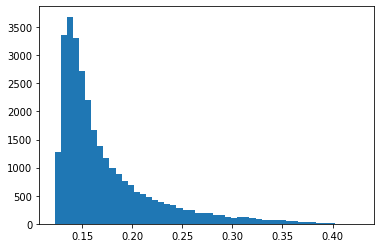

In [230]:
plt.hist(np.mean(predicts, axis=0), bins=50)

In [245]:
logreg_test['prob'] = lr_f_result

In [246]:
logreg_test[['id', 'prob']].to_csv('blend_submission.csv', index=False)